In [1]:
# from google.colab import drive, files 
# drive.mount('/content/gdrive')

import os
import tensorflow as tf 
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt 
from tensorflow.keras.layers import Activation, Conv3D, MaxPooling3D, Flatten, Dense
from tensorflow.keras.layers import Dropout, Input, BatchNormalization
from sklearn.metrics import confusion_matrix, accuracy_score
from tensorflow.keras import optimizers, losses, regularizers, metrics
from tensorflow.keras import models
from tensorflow.keras.callbacks import TensorBoard
import datetime
%load_ext tensorboard

In [2]:
!rm -rf ./logs/ # clear previous logs

data_path = '/Users/teresanoyola/Desktop/CS230/Project'
labels_path = os.path.join(data_path, '/Data/labels.csv')

train_paths = (os.path.join(data_path, 'x_train.npy'), os.path.join(data_path, 'y_train.npy'))
test_paths = (os.path.join(data_path, 'x_test.npy'), os.path.join(data_path, 'y_test.npy'))

In [3]:
def plot(name, hist):
    plt.plot(hist.history[name])
    plt.title(name)
    plt.xlabel('Epochs')
    plt.ylabel(name)
    plt.show()
    plt.clf()


def plot(opt, rates, losses, accuracies):
    x = np.arange(len(accuracies[0])) + 1

    for i in range(len(rates)):
        plt.plot(x, accuracies[i], label = f'$r$ = {rates[i]:.2e}')

    plt.xlabel('Number of epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy')
    file_name = 'accuracy_' + opt + '.png'
    plt.show()

    plt.clf()

    for i in range(len(rates)):
        plt.plot(x, losses[i], label = f'$r$ = {rates[i]:.2e}')

    plt.xlabel('Number of epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss')
    file_name = 'loss_' + opt + '.png'

    plt.show()

    plt.clf()
    
def vary_adamLR(img_size, num_classes, train_path, test_path, num = 1):
    x_train, y_train = np.load(train_path[0]), np.load(train_path[1])
    x_test, y_test = np.load(test_path[0]), np.load(test_path[1])

    rates = []
    accuracies = []
    losses = []

    i = 1.0e-6

    while i < 1.0e-1:
        print(f"Learning rate = {i:.3e}")
        cnn_model = ConvNet(img_size, num_classes, model_num = num) # create a 3D-CNN
        model = cnn_model.get_model()

        opt = optimizers.Adam(learning_rate = i)
        model.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])
        hist = model.fit(x_train, y_train.T, epochs = 10, batch_size = 9)

        accuracies.append(hist.history['accuracy'])
        losses.append(hist.history['loss'])
        rates.append(i)
        i *= 10
        print('---------------------------------------------------')

    plot('Adam', rates, losses, accuracies)


def vary_sgdLR(img_size, num_classes, train_path, test_path, num = 1):
    x_train, y_train = np.load(train_path[0]), np.load(train_path[1])
    x_test, y_test = np.load(test_path[0]), np.load(test_path[1])

    rates = []
    accuracies = []
    losses = []

    i = 1e-8

    while i < 1.0:
        print(f"Learning rate = {i:.3e}")
        cnn_model = ConvNet(img_size, num_classes, model_num = num) # create a 3D-CNN
        model = cnn_model.get_model()

        opt = optimizers.SGD(learning_rate = i)
        model.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])
        hist = model.fit(x_train, y_train.T, epochs = 15, batch_size = 9)

        accuracies.append(hist.history['accuracy'])
        losses.append(hist.history['loss'])
        rates.append(i)
        print('---------------------------------------------------')
        
        i *= 10

    plot('SGD', rates, losses, accuracies)

In [4]:
class ConvNet:
    def __init__(self, shape, num_classes, model_num):
        self.img_shape = shape
        self.num_classes = num_classes

        if model_num == 1:
            model = self.get_regular_CNN()

        elif model_num == 2:
            model = self.get_deeper_CNN()

        elif model_num == 3:
            model = self.get_wider_CNN()


        self.model = model

        self.losses = {}
        self.accuracies = {}


    def summary(self):
        self.model.summary()

    def get_model(self):
        return self.model

    def get_history(self):
        return self.history

    def get_regular_CNN(self):
        model = models.Sequential()

        # model.add(Conv3D(16, kernel_size = (3, 3, 3), input_shape = self.img_shape, kernel_regularizer = regularizers.l2(0.01)))
        model.add(Conv3D(16, kernel_size = (3, 3, 3), input_shape = self.img_shape))
        # model.add(Dropout(0.4))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size = (2, 2, 2), padding = 'valid'))

        # model.add(Conv3D(32, kernel_size = (3, 3, 3), kernel_regularizer = regularizers.l2(0.01)))
        model.add(Conv3D(16, kernel_size = (3, 3, 3), input_shape = self.img_shape))
        # model.add(Dropout(0.4))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size = (2, 2, 2), padding = 'valid'))

        # model.add(Conv3D(32, kernel_size = (3, 3, 3), kernel_regularizer = regularizers.l2(0.01)))
        model.add(Conv3D(16, kernel_size = (3, 3, 3), input_shape = self.img_shape))
        # model.add(Dropout(0.4))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size = (2, 2, 2), padding = 'valid'))

        model.add(Flatten())
        model.add(Dense(1024, activation = 'sigmoid'))
        model.add(Dropout(0.5))
        model.add(Dense(self.num_classes, activation = 'softmax'))

        return model



    def get_deeper_CNN(self):
        model = models.Sequential()

        # model.add(Conv3D(16, kernel_size = (3, 3, 3), input_shape = self.img_shape, kernel_regularizer = regularizers.l2(0.1)))
        model.add(Conv3D(16, kernel_size = (3, 3, 3), input_shape = self.img_shape))
        # model.add(Dropout(0.4))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size = (2, 2, 2), padding = 'valid'))

        # model.add(Conv3D(16, kernel_size = (3, 3, 3), kernel_regularizer = regularizers.l2(.01)))
        model.add(Conv3D(16, kernel_size = (3, 3, 3), input_shape = self.img_shape))
        # model.add(Dropout(0.4))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size = (2, 2, 2), padding = 'valid'))

        # model.add(Conv3D(32, kernel_size = (3, 3, 3), kernel_regularizer = regularizers.l2(1)))
        model.add(Conv3D(16, kernel_size = (3, 3, 3), input_shape = self.img_shape))
        # model.add(Dropout(0.4))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size = (2, 2, 2), padding = 'valid'))

        # model.add(Conv3D(32, kernel_size = (3, 3, 3), kernel_regularizer = regularizers.l2(.01)))
        model.add(Conv3D(16, kernel_size = (3, 3, 3), input_shape = self.img_shape))
        # model.add(Dropout(0.4))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size = (2, 2, 2), padding = 'valid'))

        model.add(Flatten())
        model.add(Dense(1000, activation = 'sigmoid'))
        model.add(Dropout(0.4))
        model.add(Dense(500, activation = 'sigmoid'))
        model.add(Dropout(0.2))
        model.add(Dense(self.num_classes, activation = 'softmax'))

        return model



    def get_wider_CNN(self):
        model = models.Sequential()

        model.add(Conv3D(16, kernel_size = (3, 3, 3), input_shape = self.img_shape))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size = (2, 2, 2), padding = 'valid'))

        model.add(Conv3D(128, kernel_size = (3, 3, 3)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size = (2, 2, 2), padding = 'valid'))

        model.add(Conv3D(32, kernel_size = (3, 3, 3)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size = (2, 2, 2), padding = 'valid'))

        model.add(Flatten())
        model.add(Dense(1024, activation = 'sigmoid'))
        model.add(Dense(self.num_classes, activation = 'softmax'))

        return model



    def train(self, train_paths, test_paths, num_epochs = 20, batch = 4, lr = 0.0001):
        xtr_path, ytr_path = train_paths
        xts_path, yts_path = test_paths

        x_train = np.load(xtr_path)
        y_train = np.load(ytr_path)

        x_test = np.load(xts_path)
        y_test = np.load(yts_path)

        logs = "logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
        tensorboard = TensorBoard(log_dir = logs, histogram_freq = 1)

        opt = optimizers.Adam(learning_rate = lr)
        # opt = optimizers.SGD(learning_rate = 0.0001)
        # early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 2)
        self.model.compile(optimizer = opt, loss = losses.CategoricalCrossentropy(), metrics = ['accuracy'])
        history = self.model.fit(x_train, y_train.T, epochs = num_epochs, batch_size = batch, validation_data = (x_test, y_test.T), callbacks = [tensorboard])
        # history = self.model.fit(x_train, y_train.T, epochs = num_epochs, batch_size = batch, validation_data = (x_test, y_test.T), callbacks = [early_stop])
        
        print("Finished training....\nNow Evaluating:")

        train_eval = self.model.evaluate(x_train, y_train.T, verbose = 0)
        print("Train evaluation:\n\tLoss = {}\n\tAccuracy = {:.2f}%".format(train_eval[0], train_eval[1] * 100))

        test_eval = self.model.evaluate(x_test, y_test.T, verbose = 0)
        print("Test evaluation:\n\tLoss = {}\n\tAccuracy = {}%".format(test_eval[0], test_eval[1] * 100))

        plt.plot(history.history['loss'], label = 'Loss')
        plt.plot(history.history['val_loss'], label = 'Val Loss')
        plt.title('Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()
        plt.clf()

        plt.plot(history.history['accuracy'], label = 'Accuracy')
        plt.plot(history.history['val_accuracy'], label = 'Val accuracy')
        plt.title('Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.show()
        plt.clf()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 206, 48, 58, 16)   1312      
_________________________________________________________________
activation (Activation)      (None, 206, 48, 58, 16)   0         
_________________________________________________________________
batch_normalization (BatchNo (None, 206, 48, 58, 16)   64        
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 103, 24, 29, 16)   0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 101, 22, 27, 16)   6928      
_________________________________________________________________
activation_1 (Activation)    (None, 101, 22, 27, 16)   0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 101, 22, 27, 16)   6

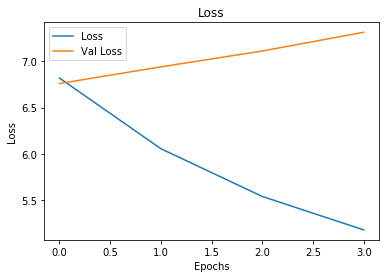

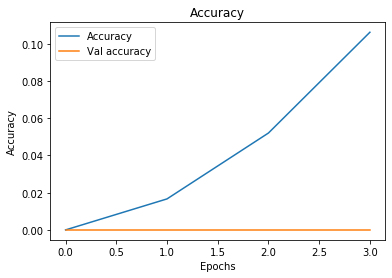

<Figure size 432x288 with 0 Axes>

In [5]:
# import numpy as np
# import data_processing as data
# import os
# import cnn


# data_path = '/Users/sunnyshah/Desktop/Spring 2020/CS 230/Project/Models/data'
# labels_path = os.path.join(data_path, 'labels.csv')


# df = data.Dataset(data_path, labels_path)

# x_train, y_train = df.get_data('train')

# np.save('x_train.npy', x_train)
# np.save('y_train.npy', y_train)

# x_test, y_test = df.get_data('test')

# np.save('x_test.npy', x_test)
# np.save('y_test.npy', y_test)


# num_classes = df.get_num_classes()
# img_size = df.get_image_size()
# print(num_classes, img_size)


#x_train = np.load('/home/ubuntu/x_train.npy')
#print(x_train.shape)

#y_train = np.load('/home/ubuntu/y_train.npy')
#print(y_train.shape)

# train_paths = (os.path.join(data_path, 'x_train.npy'), os.path.join(data_path, 'y_train.npy'))
# test_paths = (os.path.join(data_path, 'x_test.npy'), os.path.join(data_path, 'y_test.npy'))

img_size = (208, 50, 60, 3)
num_classes = 535
cnn_model = ConvNet(img_size, num_classes, model_num = 1) # create a 3D-CNN
cnn_model.summary() # print summary
cnn_model.train(train_paths, test_paths, num_epochs = 4, batch = 32, lr = 0.0001) 

del(cnn_model)

# vary_adamLR(img_size, num_classes, train_paths, test_paths, num = 1)
# vary_sgdLR(img_size, num_classes, train_paths, test_paths, num = 1)

In [6]:
%tensorboard --logdir logs/ # use this line without the % character in terminal or .py notebook to view the TensorBoard
# if using terminal or .py, go to "localhost:6006" in the browser 

In [7]:
# for p in train_paths:
#     x = np.load(p)
#     x /= 255.0
#     np.save(p, x)

# for p in test_paths:
#     x = np.load(p)
#     x /= 255.0
#     np.save(p, x)

#x = np.load(train_paths[0])
#print(x) # matrix of the 1st channel of 1st frame of 1st video in training data - is it normalized? (values are in [0, 1])

In [ ]:
!kill 1688